In [2]:
from datetime import datetime
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.keras import layers
import multiprocessing
from tensorflow.keras.models import load_model
import pickle
import shutil
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
%store -r map_cut_data_E_obs

In [4]:
%store -r data_train_E
%store -r data_val_E
%store -r label_train
%store -r label_val

In [5]:
#LOAD DATA

data_train = data_train_E # np.array con formato (#parches,#pix,#pix,#frecuencias)
label_train= label_train # np.array con formato (#parches,#pix,#pix,1)

data_val = data_val_E # np.array con formato (#parches,#pix,#pix,#frecuencias)
label_val= label_val # np.array con formato (#parches,#pix,#pix,1)


In [6]:
#CONFIGURE SESSION

# aquí simplemente le estoy pidiendo que use todos los cores de mi ordenador
# esto habría que configurarlo para aprovechar los recursos de Altamira

ncpu = multiprocessing.cpu_count()
config = tf.compat.v1.ConfigProto(allow_soft_placement=True,
                        intra_op_parallelism_threads=ncpu-1,
                        inter_op_parallelism_threads=ncpu-1)
tf.compat.v1.Session(config=config)


2023-10-01 19:34:18.938631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 19:34:18.944958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-01 19:34:18.945126: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-01 19:34:18.945226: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c10a932555b0): /proc/driver/nvidia/version does not exist


In [7]:
#DEFINE CNN MODEL
#Modelo de David, cambiando la normalización para que sea más estable

model=tf.keras.Sequential()

# primer bloque convolucional
# 16 es el número de filtros que se aplican en esta capa
# (7,7) es el tamaño en píxeles de cada filtro
# strides indica cada cuántos píxeles aplicar el filtro
# con (1,1) se aplica el filtro sobre todos los píxeles de la imagen
# con (2, 2) se aplicaría sobre uno sí uno no
# el padding indica que hacer cuando aplicas el filtro cerca de los bordes
# padding=same considera como cero los píxeles del filtro que caigan fuera de la imagen, manteniendo el tamaño original de la imagen
model.add(layers.Conv2D(16, (7, 7), input_shape=(64, 64, 1), 
                        strides=(1,1), padding='same'))
model.add(tfa.layers.GroupNormalization(groups=16))
model.add(layers.Activation('relu'))

# segundo bloque convolucional
model.add(layers.Conv2D(32, (7, 7), strides=(1,1),padding='same'))
model.add(tfa.layers.GroupNormalization(groups=32))
model.add(layers.Activation('relu'))

# reducción de dimensionalidad (a la salida tienes #pix/2)
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))  
model.add(layers.Activation('relu'))

# último bloque de convolución inversa + aumento de dimensionalidad
# al pedir strides=(2,2) estás doblando el tamaño de la imagen 
model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
model.add(tfa.layers.GroupNormalization(groups=64))
model.add(layers.Activation('relu'))

# salida con activación sigmoide para poder interpretar el output como una probabilidad
model.add(layers.Conv2D(1, (1, 1), activation='sigmoid'))

# escoger función de perdida, métricas de validación y el optimizador
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model.build(input_shape=(label_train.shape[0], 64, 64, 1)) # he tenido que añadir esta línea para que model.summary() funcione
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (2548, 64, 64, 16)       800       
 er)                                                             
                                                                 
 group_normalization (GroupN  (2548, 64, 64, 16)       32        
 ormalization)                                                   
                                                                 
 module_wrapper_1 (ModuleWra  (2548, 64, 64, 16)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (2548, 64, 64, 32)       25120     
 pper)                                                           
                                                                 
 group_normalization_1 (Grou  (2548, 64, 64, 32)       6

In [28]:
#TRAINING

# a la hora de minimizar, en vez trabajar con #parches a la vez, se trabaja
# con sub-divisiones de BATCH_SIZE parches
BATCH_SIZE=10 # no puede ser un número muy grande para no sobrecargar memoria 

EPOCHS = 2

# entrenamiento propiamente dicho
start_time=datetime.now()
print('starting at '+str(start_time))
history=model.fit(data_train, label_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
      validation_data=(data_val, label_val))
stop_time=datetime.now()
print('ended at '+str(stop_time))

# el modelo ha de guardase dentro de un directorio llamado "models" (cosas de Tensorflow)
# esto te guarda únicamente la configuración de la red y los pesos
model_name = "E_64pix_9epoch_10batch"
history_file_name = "history"
model.save(model_name) # guarda en un folder

# para guardar la evolución de la función de perdida y la accuracy durante el entrenamiento 
# habría que hacer
history_dict=history.history
with open(history_file_name, 'wb') as fp:
    pickle.dump(history_dict, fp, protocol=pickle.HIGHEST_PROTOCOL) 
print(history_dict)
shutil.move(history_file_name, model_name + "/" + history_file_name)
# esto ya lo puedes guardar en cualquier directorio


# puedes cargar cualquier modelo ya entrenado con
#model=load_model("P_64pix_1epoch_10batch") 
# y continuar entrenando, o aplicar la red en modo predicción a los datos que quieras

starting at 2023-10-01 19:56:23.090706
Epoch 1/2
255/255 [==============================] - 95s 373ms/step - loss: 0.0132 - binary_accuracy: 0.9944 - val_loss: 0.0140 - val_binary_accuracy: 0.9942
Epoch 2/2
255/255 [==============================] - 121s 476ms/step - loss: 0.0131 - binary_accuracy: 0.9945 - val_loss: 0.0137 - val_binary_accuracy: 0.9943
ended at 2023-10-01 19:59:59.854236


INFO:tensorflow:Assets written to: E_64pix_9epoch_10batch/assets


INFO:tensorflow:Assets written to: E_64pix_9epoch_10batch/assets


{'loss': [0.013245358131825924, 0.013086902908980846], 'binary_accuracy': [0.9944494366645813, 0.994472324848175], 'val_loss': [0.014019245281815529, 0.01367674209177494], 'val_binary_accuracy': [0.9942477941513062, 0.9942672848701477]}


'E_64pix_9epoch_10batch/history'

In [29]:
def prediction(model, images, path=None):
    print('start predictions')
    if path != None:
        model = load_model(path+model)
    else:
        model = load_model(model_path+model)
    predictions = model.predict(images, batch_size = BATCH_SIZE, verbose = True)
    print('end predictions')
    return predictions

In [30]:
prediction_E_64pix_9epoch_10batch = prediction(model_name, map_cut_data_E_obs, path = "./")

start predictions
319/319 [==============================] - 39s 120ms/step
end predictions


In [11]:
loss_1epoch = history_dict['loss']
val_loss_1epoch = history_dict['val_loss']

In [12]:
%store prediction_E_64pix_1epoch_10batch

Stored 'prediction_E_64pix_1epoch_10batch' (ndarray)


In [16]:
loss_3epoch = history_dict['loss']
val_loss_3epoch = history_dict['val_loss']

In [17]:
%store prediction_E_64pix_3epoch_10batch

Stored 'prediction_E_64pix_3epoch_10batch' (ndarray)


In [21]:
loss_5epoch = history_dict['loss']
val_loss_5epoch = history_dict['val_loss']

In [22]:
%store prediction_E_64pix_5epoch_10batch

Stored 'prediction_E_64pix_5epoch_10batch' (ndarray)


In [26]:
loss_7epoch = history_dict['loss']
val_loss_7epoch = history_dict['val_loss']

In [27]:
%store prediction_E_64pix_7epoch_10batch

Stored 'prediction_E_64pix_7epoch_10batch' (ndarray)


In [31]:
loss_9epoch = history_dict['loss']
val_loss_9epoch = history_dict['val_loss']

In [32]:
%store prediction_E_64pix_9epoch_10batch

Stored 'prediction_E_64pix_9epoch_10batch' (ndarray)


In [33]:
loss = loss_1epoch + loss_3epoch + loss_5epoch + loss_7epoch + loss_9epoch
val_loss = val_loss_1epoch + val_loss_3epoch + val_loss_5epoch + val_loss_7epoch + val_loss_9epoch

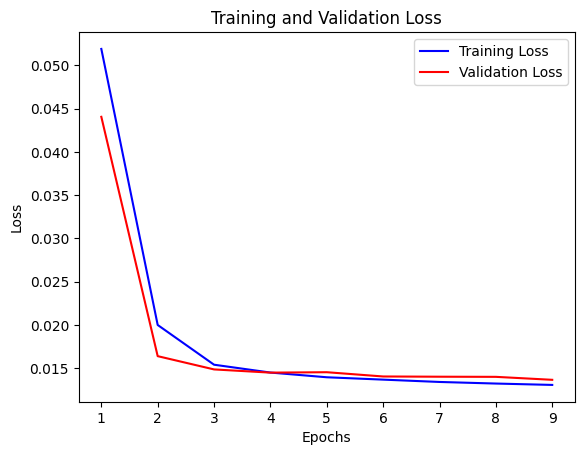

In [34]:
plt.plot(np.arange(1,10,1), loss, 'b', label='Training Loss')
plt.plot(np.arange(1,10,1), val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"Val_loss_9_epochs.png")
plt.show()

#### **Prediction after adding the foregrounds**

In [35]:
%store -r map_cut_data_E_obs_foregrounds

In [36]:
def prediction(model, images, path=None):
    print('start predictions')
    if path != None:
        model = load_model(path+model)
    else:
        model = load_model(model_path+model)
    predictions = model.predict(images, batch_size = BATCH_SIZE, verbose = True)
    print('end predictions')
    return predictions

In [37]:
prediction_E_64pix_9epoch_10batch_foregrounds = prediction("E_64pix_9epoch_10batch", map_cut_data_E_obs_foregrounds, path = "./")

start predictions
319/319 [==============================] - 32s 100ms/step
end predictions


In [38]:
%store prediction_E_64pix_9epoch_10batch_foregrounds

Stored 'prediction_E_64pix_9epoch_10batch_foregrounds' (ndarray)
